# Fund 26. Acitvation Function

- 신경망 속의 퍼셉트론 혹은 노드는 '특정 조건'을 만족하면 '활성화'되도록 디자인되었다. 
- ReLU는 입력값이 음수라면 0을 출력하고, 입력값이 0 이상이면 입력값을 그대로 출력하도록 디자인되었다. 
- 시그모이드는 입력값이 음의 무한대로 갈수록 0을 출력하고 양의 무한대로 갈수록 1을 출력하며, 0일 때는 1/2를 출력한다. 
- 이 함수는 입력값에 무관하게 0에서 1 사이의 값으로 출력하는 특징이 있으며, 따라서 2가지 상황을 구분할 때 용이하다. 
- 실제로 딥러닝에서 활성화 함수를 쓰는 결정적 이유는 딥러닝 모델의 표현력을 향상시켜주기 위해서다. (모델의 representation capacity, expressivity)
- 딥러닝 모델의 파라미터(w, b)들은 입력값 x와 선형 관계다. 곱하고 더하는 연산만 하면서 그 다음 레이어로 전달되기 때문이다. 따라서 사인 곡선처럼 직선으로 근사할 수 없는 비선형 데이터를 표현하려면 딥러닝 모델도 비선형성을 지니고 있어야 한다. 
- 이 때 쓰이는 것이 활성화 함수고, 활성화 함수를 레이어 사이에 넣어줌으로써 비선형 데이터도 표현할 수 있게 되었다. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
import tensorflow as tf

tf.random.set_seed(7879)

## 퍼셉트론
- 딥러닝 모델은 여러 개의 층으로 이루어져있다. 그 중 하나의 층을 가져와 다시 쪼개면 보통 '노드'라고 불리는 것으로 쪼개지게 되는데, 이것이 바로 퍼셉트론이다. 
- 퍼셉트론을 쌓으면 단층 퍼셉트론이 되고, 이 단층 퍼셉트론을 쌓으면 다층 퍼셉트론이 된다. 
- 활성화 함수는 신경 세포로 치면 세포체에서 일어나는 일을 맡고 있다. 들어온 신호가 특정 임계점을 넘으면 출력을 하고, 넘지 못하면 무시한다.

## 이진 계단 함수
활성화 함수는 크게 3가지 종류의 함수로 나눌 수 있다. 
1. 이진 계단 함수(Binary step function)
2. 선형 활성화 함수(Linear activation function)
3. 비선형 활성화 함수(Non-linear activaton function)  

이진 계단 함수라는 이름이 붙은 이유는 간단하다. 이 함수로 들어온 입력이 특정 임계점을 넘으면 1을, 그렇지 않으면 0을 출력하기 때문이다.  
이러한 특성 때문에 이 활성화 함수는 간단한 이진 분류 문제에서 꽤 유용하게 쓰인다. 

In [2]:
def binary_step(x, threshold=0):
    # threshold가 있는 함수를 쓰면 꼭 default 값을 설정하자
    return 0 if x < threshold else 1

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def plot_and_visualize(image_url, function, derivative=False):
    X = [-10 + x / 100 for x in range(2000)]
    y = [function(y) for y in X]
    
    plt.figure(figsize=(12, 12))
    
    # 함수 그래프
    plt.subplot(3, 2, 1)
    plt.title('function')
    plt.plot(X, y)
    
    # 함수의 미분 그래프
    plt.subplot(3, 2, 2)
    plt.title('derivative')
    if derivative:
        dev_y = [derivative(y) for y in X]
        plt.plot(X, dev_y)
    
    # 무작위 샘플들 분포
    samples = np.random.rand(1000)
    samples -= np.mean(samples)
    plt.subplot(3, 2, 3)
    plt.title('samples')
    plt.hist(samples, 100)
    
    # 활성화 함수를 통과한 샘플들 분포
    act_values = [function(y) for y in samples]
    plt.subplot(3, 2, 4)
    plt.title('activation values')
    plt.hist(act_values, 100)
    
    # 원본 이미지
    image = np.array(Image.open(image_url), dtype=np.float64)[:,:,0]/255.  # 구분을 위해 gray-scale로 확인
    image -= np.median(image)
    plt.subplot(3, 2, 5)
    plt.title('origin image')
    plt.imshow(image, cmap='gray')

    # 활성화 함수를 통과한 이미지
    activation_image = np.zeros(image.shape)
    h, w = image.shape
    for i in range(w):
        for j in range(h):
            activation_image[j][i] += function(image[j][i])
    plt.subplot(3, 2, 6)
    plt.title('activation results')
    plt.imshow(activation_image, cmap='gray')
    
    return plt
    

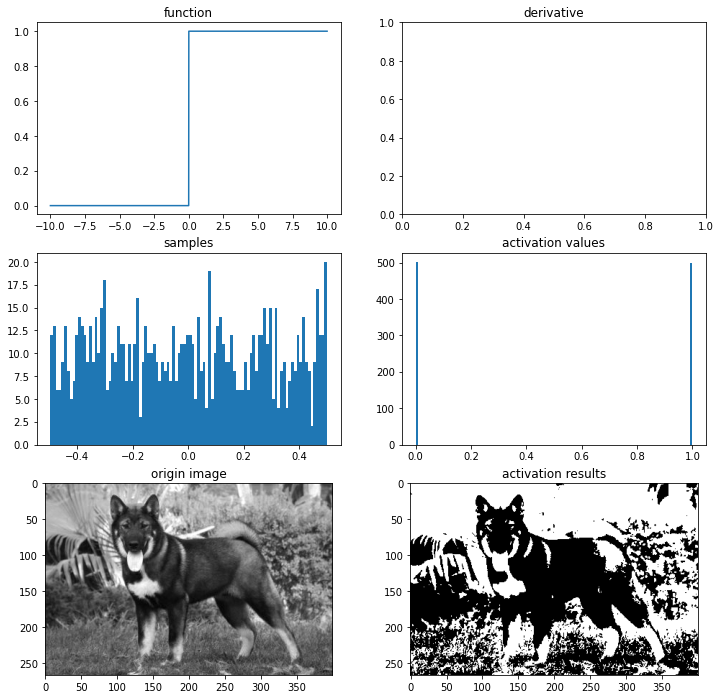

In [4]:
import os
img_path = os.getenv('HOME')+'/aiffel/activation/jindo_dog.jpg'
ax = plot_and_visualize(img_path, binary_step)
ax.show()

- 이진 계단 함수의 치역(range)는 0, 1이 된다. 
- 이진 계단 함수는 단층 퍼셉트론이라는 초기의 신경망에서 자주 사용되었다. 

In [5]:
# 퍼셉트론
class Perceptron(object):
    def __init__(self, input_size, activation_ftn, threshold=0, learning_rate=0.01):
        self.weights = np.random.randn(input_size)
        self.bias = np.random.randn(1)
        self.activation_ftn = np.vectorize(activation_ftn)
        self.learning_rate = learning_rate
        self.threshold = threshold
        
    def train(self, training_inputs, labels, epochs=100, verbose=1):
        '''
        verbose : 1 - 매 에포크 결과 출력 / 0 - 마지막 결과만 출력
        '''
        for epoch in range(epochs):
            for inputs, label in zip(training_inputs, labels):
                prediction = self.__call__(inputs)
                self.weights += self.learning_rate * (label - prediction) * inputs
                self.bias += self.learning_rate * (label - prediction)
            if verbose == 1:
                pred = self.__call__(training_inputs)
                accuracy = np.sum(pred==labels)/len(pred)
                print(f'{epoch}th epoch, accuracy : {accuracy}')
            
        if verbose == 0:
            pred = self.__call__(training_inputs)
            accuracy = np.sum(pred==labels)/len(pred)
            print(f'{epoch}th epoch, accuracy : {accuracy}')
            
    def get_weights(self):
        return self.weights, self.bias
    
    def __call__(self, inputs):
        summation = np.dot(inputs, self.weights) + self.bias
        return self.activation_ftn(summation, self.threshold)

- 이러한 신경망은 linear separable한 문제(AND gate, OR gate)를 구현할 수 있다. 

In [6]:
def scatter_plot(plt, X, y, threshold = 0, three_d=False):
    ax = plt
    if not three_d:
        area1 = np.ma.masked_where(y <= threshold, y)
        area2 = np.ma.masked_where(y > threshold, y+1)
        ax.scatter(X[:,0], X[:,1], s = area1*10, label='True')
        ax.scatter(X[:,0], X[:,1], s = area2*10, label='False')
        ax.legend()
    else:
        area1 = np.ma.masked_where(y <= threshold, y)
        area2 = np.ma.masked_where(y > threshold, y+1)
        ax.scatter(X[:,0], X[:,1], y-threshold, s = area1, label='True')
        ax.scatter(X[:,0], X[:,1], y-threshold, s = area2, label='False')
        ax.scatter(X[:,0], X[:,1], 0, s = 0.05, label='zero', c='gray')
        ax.legend()
    return ax

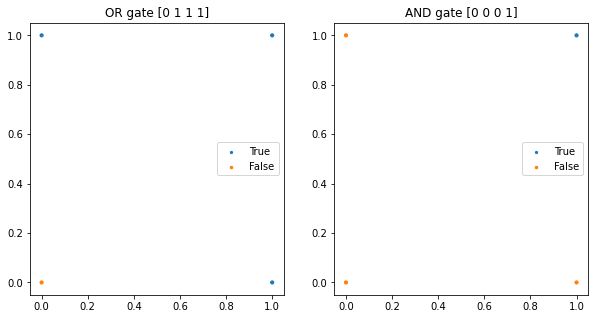

In [7]:
# AND gate, OR gate
X = np.array([[0,0], [1,0], [0,1], [1,1]])

plt.figure(figsize=(10,5))
# OR gate
or_y = np.array([x1 | x2 for x1,x2 in X])
ax1 = plt.subplot(1,2,1)
ax1.set_title('OR gate ' + str(or_y))
ax1 = scatter_plot(ax1, X, or_y)

# AND gate
and_y = np.array([x1 & x2 for x1,x2 in X])
ax2 = plt.subplot(1,2,2)
ax2.set_title('AND gate ' + str(and_y))
ax2 = scatter_plot(ax2, X, and_y)

plt.show()

In [8]:
# OR gate
or_p = Perceptron(input_size=2, activation_ftn=binary_step)
or_p.train(X, or_y, epochs=1000, verbose=0)
print(or_p.get_weights()) # 가중치와 편향값은 훈련마다 달라질 수 있습니다.

# AND gate
and_p = Perceptron(input_size=2, activation_ftn=binary_step)
and_p.train(X, and_y, epochs=1000, verbose=0)
print(and_p.get_weights()) # 가중치와 편향값은 훈련마다 달라질 수 있습니다.

999th epoch, accuracy : 1.0
(array([0.01084701, 1.52941262]), array([-0.00448205]))
999th epoch, accuracy : 1.0
(array([0.014948 , 0.7744446]), array([-0.78499015]))


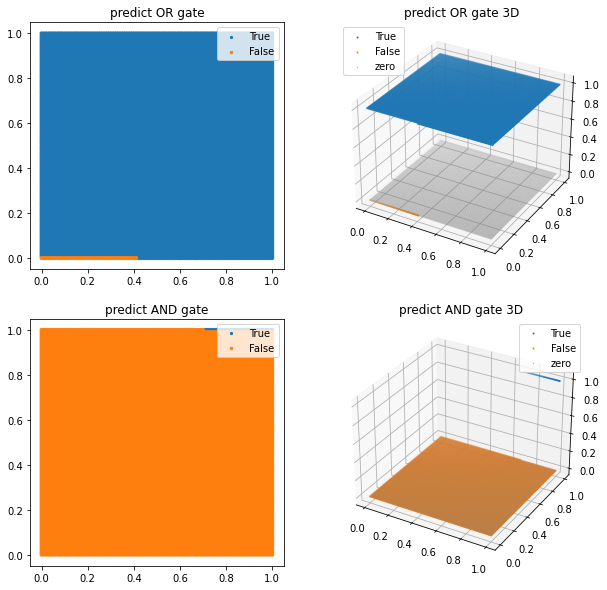

In [9]:
from itertools import product

# 그래프로 그려보기
test_X = np.array([[x/100,y/100] for (x,y) in product(range(101),range(101))])
pred_or_y = or_p(test_X)
pred_and_y = and_p(test_X)

plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,2,1)
ax1.set_title('predict OR gate')
ax1 = scatter_plot(ax1, test_X, pred_or_y)

ax2 = plt.subplot(2,2,2, projection='3d')
ax2.set_title('predict OR gate 3D')
ax2 = scatter_plot(ax2, test_X, pred_or_y, three_d=True)

ax3 = plt.subplot(2,2,3)
ax3.set_title('predict AND gate')
ax3 = scatter_plot(ax3, test_X, pred_and_y)

ax4 = plt.subplot(2,2,4, projection='3d')
ax4.set_title('predict AND gate 3D')
ax4 = scatter_plot(ax4, test_X, pred_and_y, three_d=True)

plt.show()

### 이진 계단 함수의 한계 1

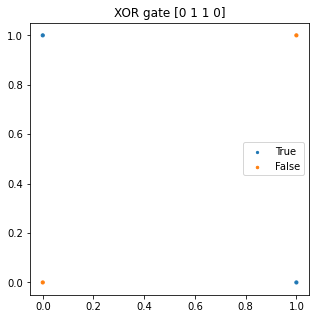

In [10]:
# XOR gate
threshold = 0
X = np.array([[0,0], [1,0], [0,1], [1,1]])

plt.figure(figsize=(5,5))
xor_y = np.array([x1 ^ x2 for x1,x2 in X])
plt.title('XOR gate '+ str(xor_y))
plt = scatter_plot(plt, X, xor_y)
plt.show()

999th epoch, accuracy : 0.25
(array([ 0.00240009, -0.00851413]), array([0.00673075]))


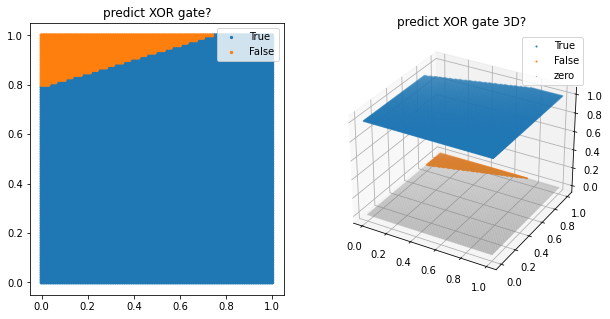

In [11]:
# XOR gate가 풀릴까?
xor_p = Perceptron(input_size=2, activation_ftn=binary_step, threshold=threshold)
xor_p.train(X, xor_y, epochs=1000, verbose=0)
print(xor_p.get_weights())

# 그래프로 그려보기
test_X = np.array([[x/100,y/100] for (x,y) in product(range(101),range(101))])
pred_xor_y = xor_p(test_X)

plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
ax1.set_title('predict XOR gate?')
ax1 = scatter_plot(ax1, test_X, pred_xor_y)

ax2 = plt.subplot(1,2,2, projection='3d')
ax2.set_title('predict XOR gate 3D?')
ax2 = scatter_plot(ax2, test_X, pred_xor_y, three_d=True)

plt.show()

- 단층 퍼셉트론은 XOR gate를 구현할 수 없다. XOR gate의 진리값 그래프를 하나의 선으로 구분할 수 없기 때문이다. 
- 여러 층을 쌓아 이를 해결할 수 있는데, 이런 모델을 다층 퍼셉트론(multi-layer perceptron, MLP)라고 한다.  

### 이진 계단 함수의 한계 2
- 층만 쌓으면 이진 계단 함수를 이용한 모델도 비선형적 데이터를 예측할 수 있다. 하지만 몇 가지 큰 단점이 있다. 
- 역전파 알고리즘을 사용하지 못한다. 이진 계단 함수는 0에서는 미분이 안 될뿐더러, 0인 부분을 제외하고 미분을 한다고 해도 미분값이 모두 0이 나온다. 
- 또한 다중 출력을 할 수 없다. 이진 계단 함수는 출력을 1 또는 0으로 밖에 주지 못하기 때문에 다양한 클래스 구분 문제는 해결할 수 없다. 
- 이진 계단 함수는 초기의 퍼셉트론에서 쓰이던 것으로 이런 것이 있었구나 정도만 이해하자!  


## 선형 활성화 함수
- 선형 활성화 함수를 사용한 모델은 이진 계단 함수를 사용한 모델과 다르게 다중 출력이 가능하다. 
- 또한 미분이 가능해서 역전파 알고리즘 또한 사용할 수 있다. 

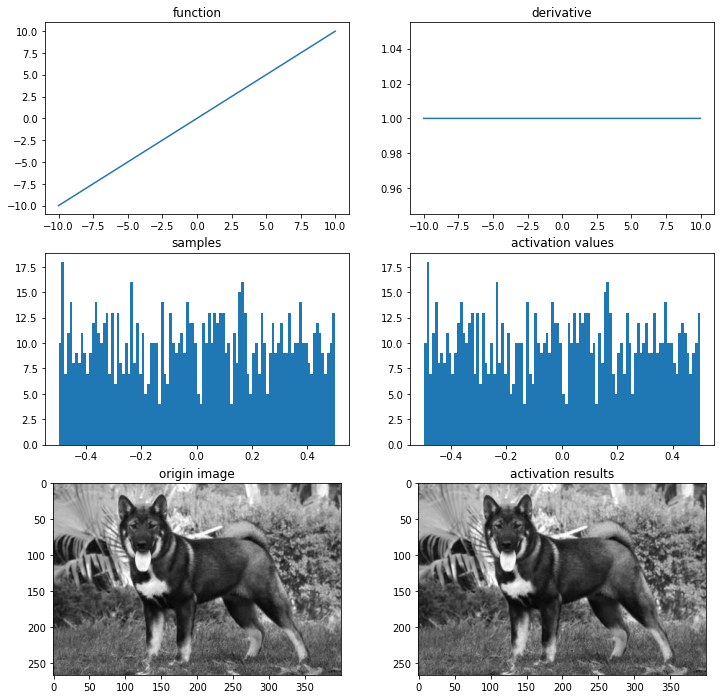

In [12]:
import os
img_path = os.getenv('HOME')+'/aiffel/activation/jindo_dog.jpg'

# 선형 함수
def linear(x):
    return x

def dev_linear(x):
    return 1

# 시각화
ax = plot_and_visualize(img_path, linear, dev_linear)
ax.show()

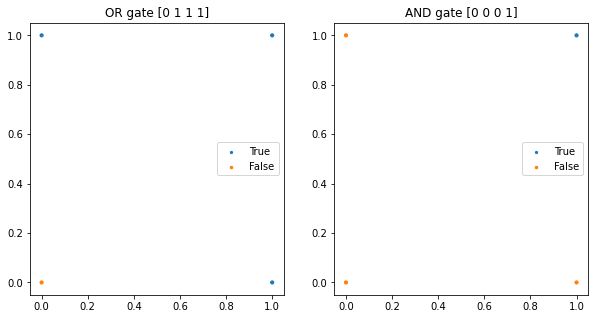

In [13]:
# AND gate, OR gate
threshold = 0
X = np.array([[0,0], [1,0], [0,1], [1,1]])

plt.figure(figsize=(10,5))
# OR gate
or_y = np.array([x1 | x2 for x1,x2 in X])
ax1 = plt.subplot(1,2,1)
ax1.set_title('OR gate ' + str(or_y))
ax1 = scatter_plot(ax1, X, or_y)

# AND gate
and_y = np.array([x1 & x2 for x1,x2 in X])
ax2 = plt.subplot(1,2,2)
ax2.set_title('AND gate ' + str(and_y))
ax2 = scatter_plot(ax2, X, and_y)

plt.show()

In [14]:
import tensorflow as tf

# OR gate model
or_linear_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,), dtype='float64'),
    tf.keras.layers.Dense(1, activation='linear')
])
or_linear_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
or_linear_model.summary()

# AND gate model
and_linear_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,), dtype='float64'),
    tf.keras.layers.Dense(1, activation='linear')
])
and_linear_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
and_linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [15]:
or_linear_model.fit(X, or_y, epochs=1000, verbose=0)
and_linear_model.fit(X, and_y, epochs=1000, verbose=0)
print('done')

done


/opt/conda/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


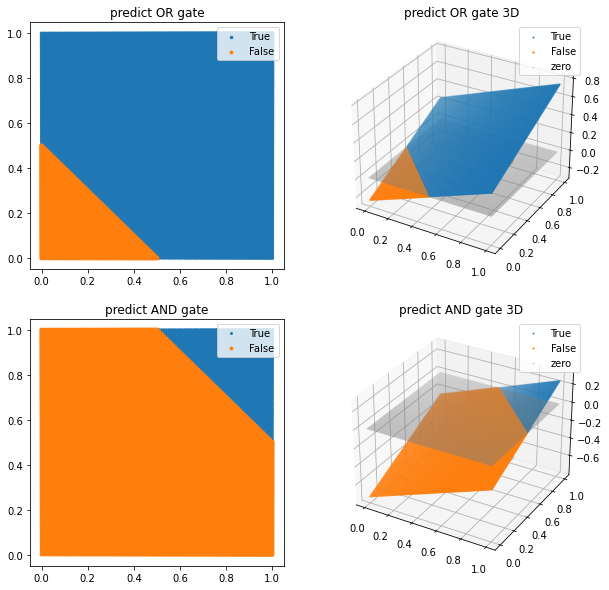

In [16]:
# 그래프로 그려보기
test_X = np.array([[x/100,y/100] for (x,y) in product(range(101),range(101))])
pred_or_y = or_linear_model(test_X)
pred_and_y = and_linear_model(test_X)

plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,2,1)
ax1.set_title('predict OR gate')
ax1 = scatter_plot(ax1, test_X, pred_or_y, threshold=0.5)

ax2 = plt.subplot(2,2,2, projection='3d')
ax2.set_title('predict OR gate 3D')
ax2 = scatter_plot(ax2, test_X, pred_or_y, threshold=0.5, three_d=True)

ax3 = plt.subplot(2,2,3)
ax3.set_title('predict AND gate')
ax3 = scatter_plot(ax3, test_X, pred_and_y, threshold=0.5)

ax4 = plt.subplot(2,2,4, projection='3d')
ax4.set_title('predict AND gate 3D')
ax4 = scatter_plot(ax4, test_X, pred_and_y, threshold=0.5, three_d=True)

plt.show()

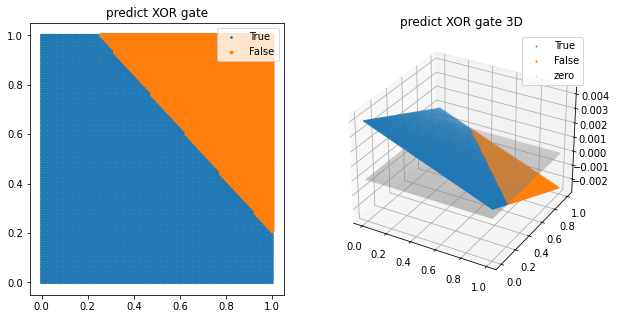

In [17]:
# XOR gate
xor_linear_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,), dtype='float64'),
    tf.keras.layers.Dense(1, activation='linear')
])
xor_linear_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
xor_linear_model.fit(X, xor_y, epochs=1000, verbose=0)

# 그래프로 그려보기
test_X = np.array([[x/100,y/100] for (x,y) in product(range(101),range(101))])
pred_xor_y = xor_linear_model(test_X)

plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
ax1.set_title('predict XOR gate')
ax1 = scatter_plot(ax1, test_X, pred_xor_y, threshold=0.5)

ax2 = plt.subplot(1,2,2, projection='3d')
ax2.set_title('predict XOR gate 3D')
ax2 = scatter_plot(ax2, test_X, pred_xor_y, threshold=0.5, three_d=True)

plt.show()

- 마찬가지로 XOR gate는 구현할 수 없다. 선 하나로는 나눌 수 없기 때문이다. 
- 선형 활성화 함수의 한계는 비선형적 특성을 지닌 데이터를 예측하지 못한다.  


## 비선형 활성화 함수 - 시그모이드, Softmax

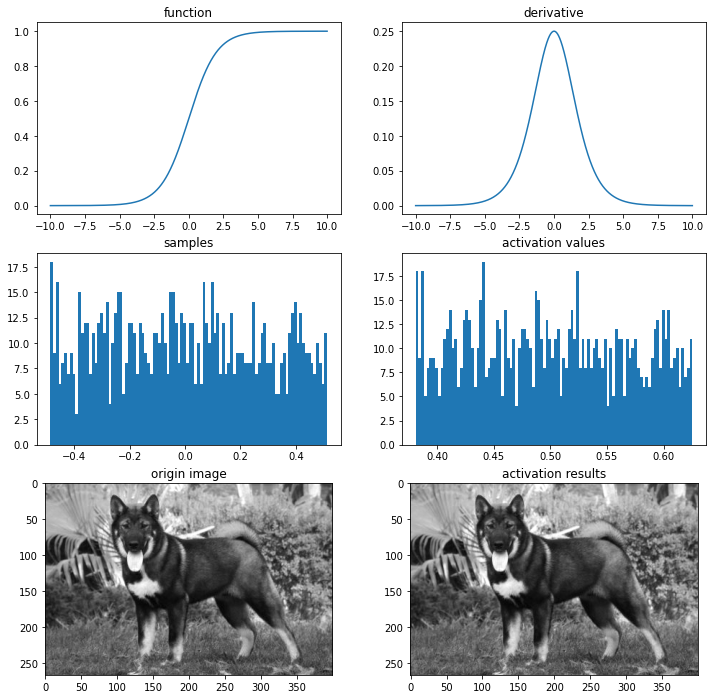

In [18]:
import os
img_path = os.getenv('HOME')+'/aiffel/activation/jindo_dog.jpg'

def sigmoid(x):
    return 1 / (1 + np.exp(-x).astype(np.float64))

def dev_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

# 시각화
ax = plot_and_visualize(img_path, sigmoid, dev_sigmoid)
ax.show()

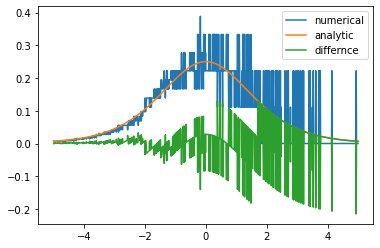

In [19]:
# 수치 미분
def num_derivative(x, function):
    h = 1e-15 # 이 값을 바꾸어 가며 그래프를 확인해 보세요
    numerator = function(x+h)-function(x)
    return numerator/h

# 두 그래프의 차이
diff_X = [-5+x/100 for x in range(1001)]
dev_y = np.array([dev_sigmoid(x) for x in diff_X])
num_dev_y = np.array([num_derivative(x, sigmoid) for x in diff_X])

diff_y = dev_y - num_dev_y
plt.plot(diff_X, num_dev_y, label='numerical')
plt.plot(diff_X, dev_y, label='analytic')
plt.plot(diff_X, diff_y, label='differnce')
plt.legend()

plt.show()

시그모이드 함수에는 두 가지 큰 단점이 있다. 
- 시그모이드는 0 도는 1에서 포화(saturate)된다. 이렇게 포화되면 gradient가 0과 아주 가까워지고, 역전파에서 이 gradient가 온 역전파 값에 곱해지게 되는데 그 이후로 전파되는 역전파 값이 0에 근접하게 되어 사실상 가중치 업데이트가 일어나지 않게 된다. (kill the gradient)
- 시그모이드 함수의 출력은 0이 중심(zero-centered)이 아니다. 따라서 훈련의 시간이 아주 오래 걸린다. (upstream gradient의 부호에 따라 노드의 가중치가 모두 양의 방향으로 업데이트되거나, 음의 방향으로 업데이트가 되기 때문)  

이러한 단점들 때문에 최근에는 자주 사용하지 않는다고 한다. 

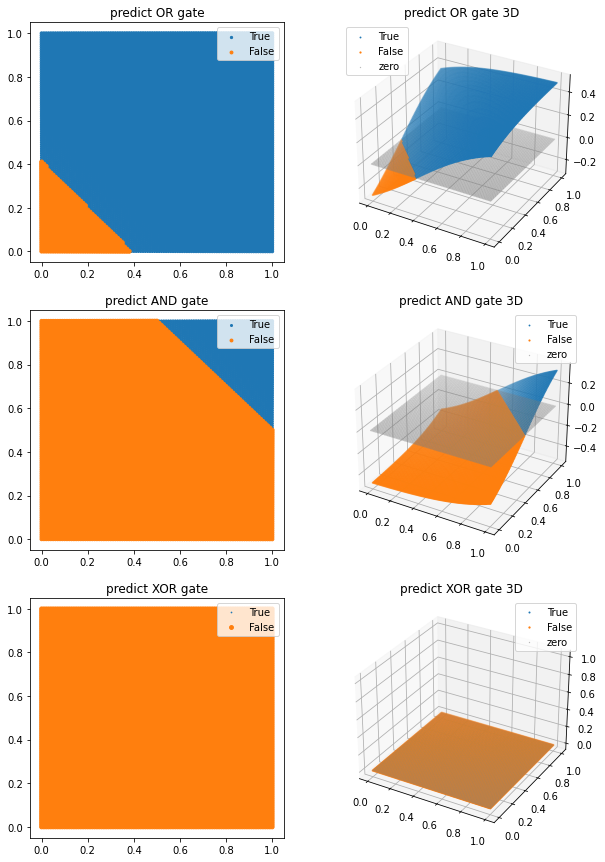

In [20]:
# OR gate
or_sigmoid_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
or_sigmoid_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
or_sigmoid_model.fit(X, or_y, epochs=1000, verbose=0)

# AND gate
and_sigmoid_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
and_sigmoid_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
and_sigmoid_model.fit(X, and_y, epochs=1000, verbose=0)

# XOR gate
xor_sigmoid_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
xor_sigmoid_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
xor_sigmoid_model.fit(X, xor_y, epochs=1000, verbose=0)

# 그래프로 그려보기
test_X = np.array([[x/100,y/100] for (x,y) in product(range(101),range(101))])
pred_or_y = or_sigmoid_model(test_X)
pred_and_y = and_sigmoid_model(test_X)
pred_xor_y = xor_sigmoid_model(test_X)

plt.figure(figsize=(10,15))
ax1 = plt.subplot(3,2,1)
ax1.set_title('predict OR gate')
ax1 = scatter_plot(ax1, test_X, pred_or_y, threshold=0.5)

ax2 = plt.subplot(3,2,2, projection='3d')
ax2.set_title('predict OR gate 3D')
ax2 = scatter_plot(ax2, test_X, pred_or_y, threshold=0.5, three_d=True)

ax3 = plt.subplot(3,2,3)
ax3.set_title('predict AND gate')
ax3 = scatter_plot(ax3, test_X, pred_and_y, threshold=0.5)

ax4 = plt.subplot(3,2,4, projection='3d')
ax4.set_title('predict AND gate 3D')
ax4 = scatter_plot(ax4, test_X, pred_and_y, threshold=0.5, three_d=True)

ax5 = plt.subplot(3,2,5)
ax5.set_title('predict XOR gate')
ax5 = scatter_plot(ax5, test_X, pred_xor_y, threshold=0.5)

ax6 = plt.subplot(3,2,6, projection='3d')
ax6.set_title('predict XOR gate 3D')
ax6 = scatter_plot(ax6, test_X, pred_xor_y, threshold=0.5, three_d=True)

plt.show()

- XOR gate는 제대로 구현하지 못했다. 비선형 함수들도 이를 구현하지 못하는 것이 아니라 좀 더 특수한 비선형 함수가 필요하다. 
- 2차 다항식을 추가한 시그모이드 함수를 사용한다면 XOR gate를 구현할 수 있다. 
- 이 밖에도 레이어를 추가해준다면 XOR gate를 구현할 수 있다. 

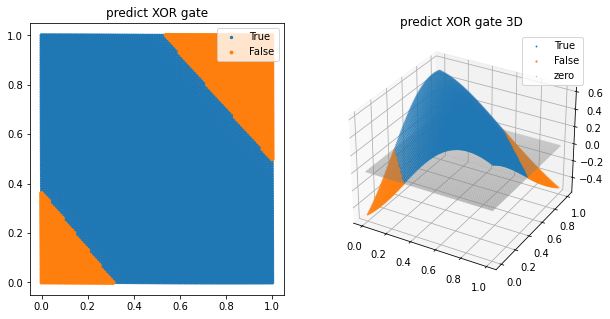

In [21]:
# 레이어를 추가했을 때
# XOR gate
xor_sigmoid_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(2, activation='sigmoid'), # 2 nodes로 변경
    tf.keras.layers.Dense(1)
])
xor_sigmoid_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
xor_sigmoid_model.fit(X, xor_y, epochs=1000, verbose=0)

plt.figure(figsize=(10,5))
pred_xor_y = xor_sigmoid_model(test_X)

ax1 = plt.subplot(1,2,1)
ax1.set_title('predict XOR gate')
ax1 = scatter_plot(ax1, test_X, pred_xor_y, threshold=0.5)

ax2 = plt.subplot(1,2,2, projection='3d')
ax2.set_title('predict XOR gate 3D')
ax2 = scatter_plot(ax2, test_X, pred_xor_y, threshold=0.5, three_d=True)

plt.show()

- 시그모이드는 이진 분류에 많이 쓰이고, Softmax는 10가지, 100가지 class 등 class 수에 제한없이 '각 class일 확률'을 구할 때 쓰인다. 
- Softmax의 가장 큰 특징은, 확률의 성질인 모든 경우의 수의 확률을 더하면 1이 되는 성질을 갖고, 따라서 모델의 마지막 layer에서 활용된다.  


##  비선형 활성화 함수 - 하이퍼볼릭 탄젠트

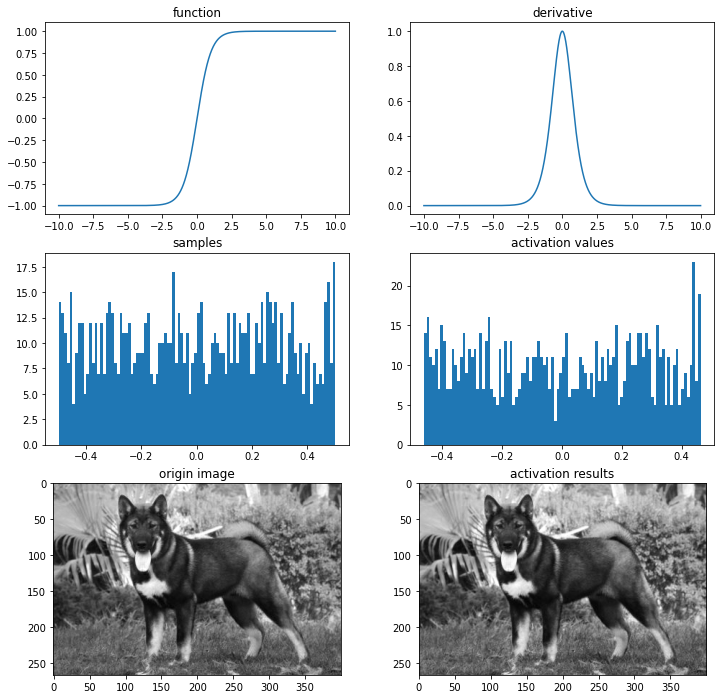

In [22]:
import os
img_path = os.getenv('HOME')+'/aiffel/activation/jindo_dog.jpg'

# 하이퍼볼릭 탄젠트 함수
def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def dev_tanh(x):
    return 1-tanh(x)**2

# 시각화
ax = plot_and_visualize(img_path, tanh, dev_tanh)
ax.show()

- 이 또한 -1 또는 1에서 포화된다는 단점이 있다.  

## 비선형 활성화 함수 - ReLU

$f(x) = max(0, x)$

ReLU(rectified linear unit) 함수는 최근 가장 많이 사용되고 있는 활성화 함수다. 

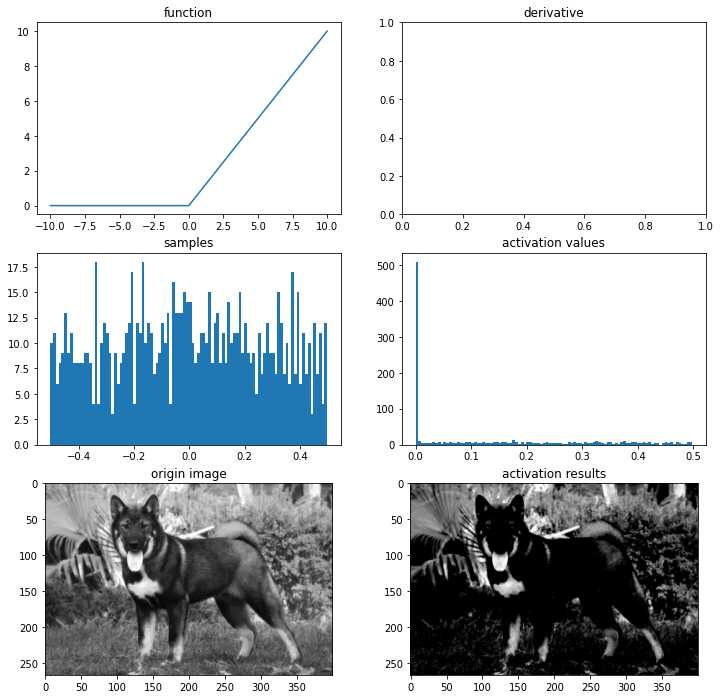

In [23]:
import os
img_path = os.getenv('HOME')+'/aiffel/activation/jindo_dog.jpg'

# relu 함수
def relu(x):
    return max(0,x)

# 시각화
ax = plot_and_visualize(img_path, relu)
ax.show()

- ReLU를 사용한 모델은 하이퍼볼릭 탄젠트를 사용한 모델보다 몇 배 더 빠르게 훈련이 된다. 이는 시그모이드나 하이퍼볼릭 탄젠트처럼 비용이 높은(exponential과 같은) 연산을 사용하지 않기 때문에 처리 속도가 빠르다. 
- ReLU는 0을 제외한 구간에서 미분이 가능하다. (0의 경우 우미분과 좌미분 값이 다르기 때문에 미분이 불가능, 따라서 무작위하게 0 또는 1을 출력)

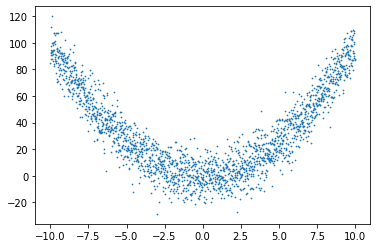

In [24]:
q_X = np.array([-10+x/100 for x in range(2001)])
q_y = np.array([(x)**2 + np.random.randn(1)*10 for x in q_X])
plt.scatter(q_X, q_y, s=0.5)

In [25]:
approx_relu_model_p = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(6, activation='relu'), # 6 nodes 병렬 연결
    tf.keras.layers.Dense(1)
])
approx_relu_model_p.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), metrics=['accuracy'])
approx_relu_model_p.fit(q_X, q_y, batch_size=32, epochs=100, verbose=0)

approx_relu_model_s = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(2, activation='relu'),# 2 nodes 직렬로 3번 연결
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(1)
])
approx_relu_model_s.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), metrics=['accuracy'])
approx_relu_model_s.fit(q_X, q_y, batch_size=32, epochs=100, verbose=0)

approx_relu_model_p.summary()
approx_relu_model_s.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 6)                 12        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 6         
____________________________________

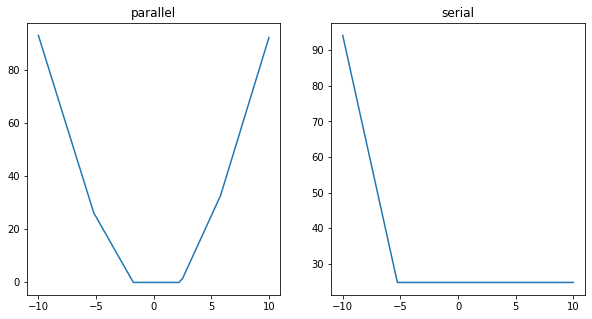

In [26]:
q_test_X = q_X.reshape((*q_X.shape,1))
plt.figure(figsize=(10,5))

ax1 = plt.subplot(1,2,1)
ax1.set_title('parallel')
pred_y_p = approx_relu_model_p(q_test_X)
ax1.plot(q_X, pred_y_p)

ax2 = plt.subplot(1,2,2)
ax2.set_title('serial')
pred_y_s = approx_relu_model_s(q_test_X)
ax2.plot(q_X, pred_y_s)

plt.show()

- ReLU 함수를 사용해도 충분히 비선형적 데이터를 예측해 낼 수 있고, 파라미터 수가 같더라도 노드를 병렬로 쌓은 것이 직렬보다 더 좋은 결과를 냈다. 
- ReLU 함수의 단점은 출력값이 0이 중심이 아니고, Dying ReLU이다. 노드의 가중치가 업데이트되어 가중치 값에 의해 입력값 x에 상관없이 0이하로 나온다면, 이후의 업데이트에서는 그래디언트가 항상 0이 되어 가중치 업데이트가 일어나지 않게 된다. 따라서, 노드가 죽어버린다. 
- 이러한 문제는 learning rate를 크게 잡을 때 자주 발생한다. 

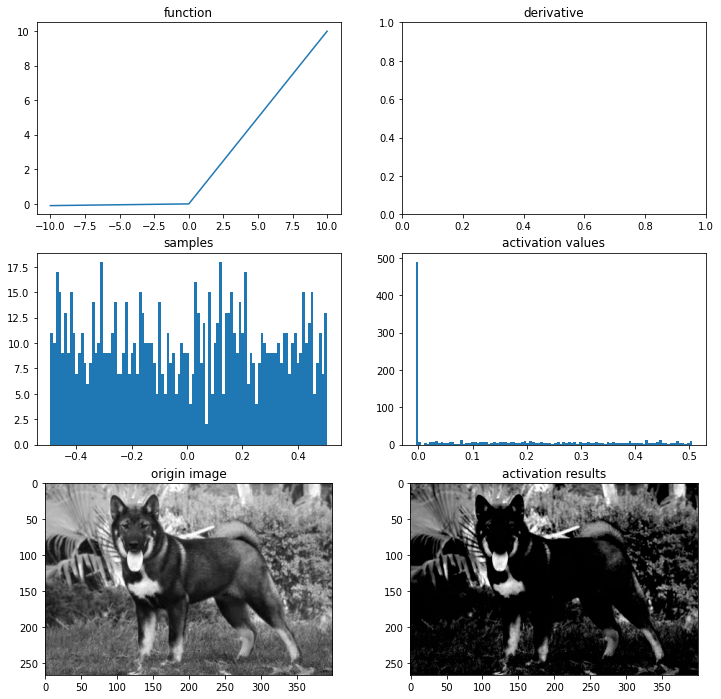

In [27]:
import os
img_path = os.getenv('HOME')+'/aiffel/activation/jindo_dog.jpg'

# leaky relu 함수
def leaky_relu(x):
    return max(0.01*x,x)

# 시각화
ax = plot_and_visualize(img_path, leaky_relu)
ax.show()

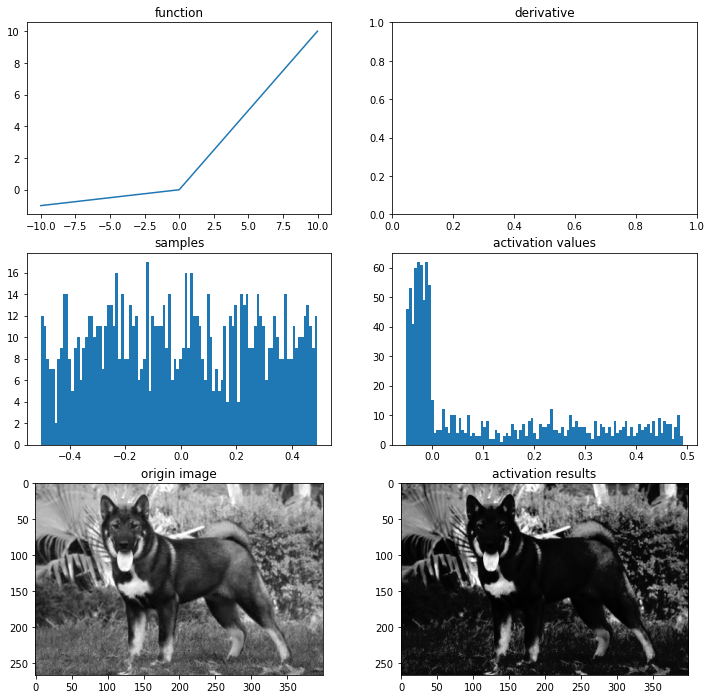

In [28]:
# PReLU 함수
def prelu(x, alpha):
    return max(alpha*x,x)

# 시각화
ax = plot_and_visualize(img_path, lambda x: prelu(x, 0.1)) # parameter alpha=0.1일 때

ax.show()

- Leaky ReLU와 유사하지만 새로운 파라미터를 추가해 0 미만일 때의 기울기가 훈련되게 했다. 

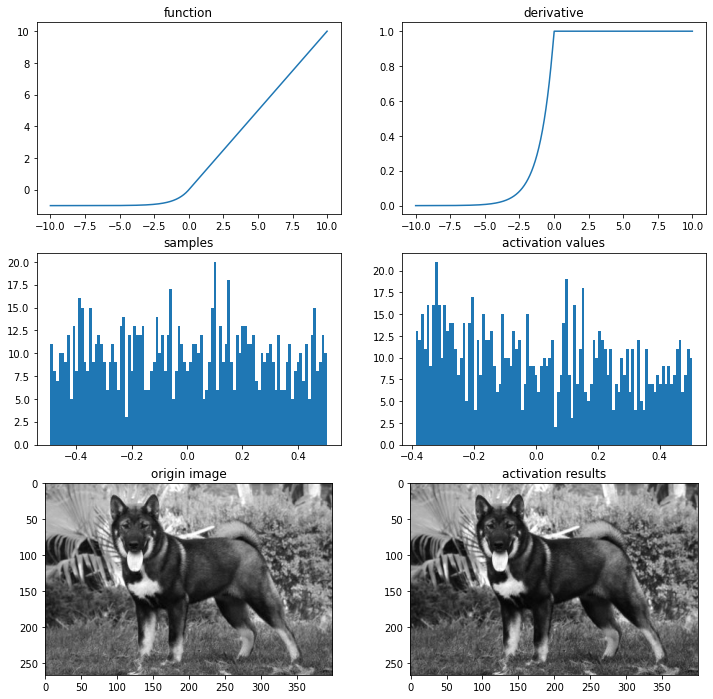

In [29]:
# elu 함수
def elu(x, alpha):
    return x if x > 0 else alpha*(np.exp(x)-1)

def dev_elu(x, alpha):
    return 1 if x > 0 else elu(x, alpha) + alpha

# 시각화
ax = plot_and_visualize(img_path, lambda x: elu(x, 1), lambda x: dev_elu(x, 1)) # alpha가 1일 때
ax.show()

- 이 함수의 단점은 exponential 연산이 들어가서 계산 비용이 높아졌다. 